## A11535519 - Justin Laughlin
### MAE 290A: Homework 2 (10/19/17)
### Problem 3

In [1]:
# Import necessary packages & configure settings
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import timeit
import time

%matplotlib inline
fs_med = 16 # medium font size for plots

<img src="hw2_3.png">

### Part 1: Discretize equation & BCs 

Using the second order finite difference approximation:
$$\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1} - 2 u_i + u_{i-1}}{h^2}$$

We can discretize eq.(1) as
$$u_{i+1} - 2 u_i + u_{i-1} = h^2 \left[ \cos{2 \pi x_i} - 1 \right]$$

Also using a Right Riemann Sum we can approximate the integral boundary condition as such,
$$\int_0^1 u(x) \, dx \approx h \cdot \sum_{i=2}^N u_i = 0 \rightarrow \sum_{i=2}^N u_i = 0 $$

$x=0$ corresponds to the left-most node, $x_1$, so the first boundary condition is simply 
$$u(0) = u_1 = 0$$

### Part 2: Rewrite eq.(1) in matrix form

### Re-writing discretized equation in matrix form ($\mathbf{A} \cdot \mathbf{u} = \mathbf{f}$)

Constructing the matrix for $N=7$... Note that we cannot satisfy the finite difference equation at $i=N$; we therefore use that row to enforce the integral boundary condition. Also $f(0)=f(1)=0$ by definition of $f(x)$.

$$\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & -2 & 1 & 0 & 0 & 0 & 0\\
0 & 1 & -2 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & -2 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & -2 & 1 & 0\\
0 & 0 & 0 & 0 & 1 & -2 & 1\\
0 & 1 & 1 & 1 & 1 & 1 & 1\\
\end{pmatrix}
\begin{pmatrix}
u_1 \\
u_2 \\
u_3 \\
u_4 \\
u_5 \\
u_6 \\
u_7 \\
\end{pmatrix} =
h^2 \begin{pmatrix}
0 \\
\cos{(2\pi x_2)} - 1 \\
\cos{(2\pi x_3)} - 1 \\
\cos{(2\pi x_4)} - 1 \\
\cos{(2\pi x_5)} - 1 \\
\cos{(2\pi x_6)} - 1 \\
0 
\end{pmatrix}$$




### Part 3: Solve for $A^{-1}$ using the Sherman-Morrison formula

Say we have the tridiagonal matrix corresponding to the system above without the integral boundary condition:
$$\hat{A} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & -2 & 1 & 0 & 0 & 0 & 0\\
0 & 1 & -2 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & -2 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & -2 & 1 & 0\\
0 & 0 & 0 & 0 & 1 & -2 & 1\\
0 & 0 & 0 & 0 & 0 & 1 & -2\\
\end{pmatrix}$$

Being a tri-diagonal matrix we can easily solve this in $\mathcal{O}(N)$ time using LU decomposition!! Once we have $\hat{A}^{-1}$ we can apply Sherman-Morrisan formula to find $A^{-1}$ with the addition of the following dyadic product:

$$A = \hat{A} + u \otimes v$$
$$u = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 1\\
\end{pmatrix}^T$$
$$v = \begin{pmatrix}
0 & 1 & 1 & 1 & 1 & 0 & 3\\
\end{pmatrix}^T$$

The Sherman-Morrison formula states

$$(A + u \otimes v)^{-1} = A^{-1} - \frac{(A^{-1} \cdot u) \otimes (v\cdot A^{-1})}{1 + \lambda}, ~~~~~~ \lambda = v\cdot A^{-1} \cdot u$$

Let's calculate $\hat{A}^{-1}$ using LU decomposition. To do so we first find the LU decomposition of $A$ (in scipy's implementation $A=PLU$, then because 
$$PLU A^{-1} = I_N$$
where $I_N$ is the identity matrix of size $N$, we can solve for $A^{-1}$ using forward & back substitution for each column of $A^{-1}$ one at a time:

In [2]:
# Forward substitution
# Solves Ly=f when L is lower diagonal
def fsub(L,f):
    # Initialize
    N = len(f)
    y = np.ndarray((N,), dtype=np.double)
    y[0] = f[0]/L[0,0]
    
    # Forward sub
    for j in np.arange(1,N):
        y[j] = (f[j] - np.dot(L[j,0:j],y[0:j]))/L[j,j]
    
    return y

# Backward substitution
# Solves Ux=y when U is upper diagonal
def bsub(U,y):
        # Initialize
    N = len(y)
    x = np.ndarray((N,), dtype=np.double)
    x[-1] = y[-1]/U[N-1,N-1]
    
    # Backward sub
    for j in np.arange(N-2,-1,-1):
        x[j] = (y[j] - np.dot(U[j,(j+1):],x[(j+1):]))/U[j,j]
    
    return x

# Solve for the inverse of A using LU decomposition
def LUinv(A):
    N = len(A)
    Ainv = np.ndarray((N,N), dtype=np.double)
    # Perform LU decomposition. In scipy's implementation A = PLU
    P, L, U = linalg.lu(A)
    
    # Now we solve for A^{-1} one column at a time:
    for j in np.arange(N):
        Icol = np.zeros((N,))
        Icol[j] = 1
        F = np.dot(P.T,Icol)
        y = fsub(L,F)
        Ainv[:,j] = bsub(U,y)
        
    return Ainv

In [3]:
Ahat = np.array(([[1, 0, 0, 0, 0, 0, 0],
[0, -2, 1, 0, 0, 0, 0],
[0, 1, -2, 1, 0, 0, 0],
[0, 0, 1, -2, 1, 0, 0],
[0, 0, 0, 1, -2, 1, 0],
[0, 0, 0, 0, 1, -2, 1],
[0, 0, 0, 0, 0, 1, -2]]), dtype=np.double)

Ahatinv = LUinv(Ahat)

Now that we have calculated $\hat{A}^{-1}$ using LU decomposition we can calculate $A^{-1}$ using the Sherman-Morrison Formula

In [4]:
# Construct A so we can check that A^{-1} was calculated properly...
A = np.array(([[1, 0, 0, 0, 0, 0, 0],
[0, -2, 1, 0, 0, 0, 0],
[0, 1, -2, 1, 0, 0, 0],
[0, 0, 1, -2, 1, 0, 0],
[0, 0, 0, 1, -2, 1, 0],
[0, 0, 0, 0, 1, -2, 1],
[0, 1, 1, 1, 1, 1, 1]]), dtype=np.double)

N = len(Ahat)
h = 1/(np.double(N)-1)
usm = np.zeros((N,))
usm[-1] = 1
vsm = np.ones((N,))
vsm[0],vsm[-1],vsm[-2] = 0,3,0

lambdasm = np.dot(np.dot(vsm,Ahatinv),usm)
Ainv = Ahatinv - np.outer(np.dot(Ahatinv,usm),np.dot(vsm,Ahatinv))/(1+lambdasm)
Ainv

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.71428571, -0.47619048, -0.28571429, -0.14285714,
        -0.04761905,  0.04761905],
       [-0.        , -0.42857143, -0.95238095, -0.57142857, -0.28571429,
        -0.0952381 ,  0.0952381 ],
       [-0.        , -0.14285714, -0.42857143, -0.85714286, -0.42857143,
        -0.14285714,  0.14285714],
       [-0.        ,  0.14285714,  0.0952381 , -0.14285714, -0.57142857,
        -0.19047619,  0.19047619],
       [-0.        ,  0.42857143,  0.61904762,  0.57142857,  0.28571429,
        -0.23809524,  0.23809524],
       [-0.        ,  0.71428571,  1.14285714,  1.28571429,  1.14285714,
         0.71428571,  0.28571429]])

Check that the $A^{-1}$ we calculated is correct by comparing $A \cdot A^{-1}$ with the identity matrix:

In [5]:
np.isclose(np.dot(A,Ainv),np.eye(N))

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]], dtype=bool)

Now let's plot $u$

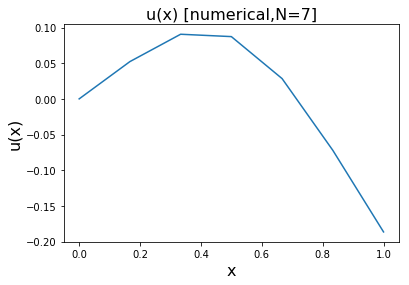

In [6]:
x = np.linspace(0,1,N)
f = h**2*(np.cos(2*np.pi*x)-1)
u = np.dot(Ainv,f)
plt.plot(x,u)
plt.ylabel('u(x)', fontsize=fs_med)
plt.xlabel('x', fontsize=fs_med)
plt.title('u(x) [numerical,N=7]', fontsize=fs_med)

### For N=30 Solve for $A^{-1}$ using Sherman-Morrison. Solve for $u$

In [7]:
N = 30
h = 1/(np.double(N)-1)

# Construct the tridiagonal matrix, Ahat
# np.diag(v,k) for some vector v, constructs a 2d array with v on the kth diagonal
Ahat = np.diag(-2*np.ones((N,)),0) + np.diag(np.ones((N-1,)),1) + np.diag(np.ones((N-1,)),-1)
Ahat[1,0], Ahat[0,1] = 0, 0

Ahatinv = LUinv(Ahat)

In [15]:
usm = np.zeros((N,))
usm[-1] = 1
vsm = np.ones((N,))
vsm[0],vsm[-1],vsm[-2] = 0,3,0

lambdasm = np.dot(np.dot(vsm,Ahatinv),usm)
Ainv = Ahatinv - np.outer(np.dot(Ahatinv,usm),np.dot(vsm,Ahatinv))/(1+lambdasm)
print('Upper right 5x5 of A^{-1}:\n\n',Ainv[0:5,0:5])

Upper right 5x5 of A^{-1}:

 [[-0.5        -0.         -0.         -0.         -0.        ]
 [-0.         -0.93333333 -0.86896552 -0.80689655 -0.74712644]
 [-0.         -0.86666667 -1.73793103 -1.6137931  -1.49425287]
 [-0.         -0.8        -1.60689655 -2.42068966 -2.24137931]
 [-0.         -0.73333333 -1.47586207 -2.22758621 -2.98850575]]


In [9]:
x = np.linspace(0,1,N)
f = h**2*(np.cos(2*np.pi*x)-1)
u=np.dot(Ainv,f)
u

array([ 0.        ,  0.00999712,  0.01996644,  0.02982587,  0.03944283,
        0.04864052,  0.05720611,  0.06490075,  0.07147071,  0.07665923,
        0.08021858,  0.08192158,  0.08157226,  0.07901503,  0.07414193,
        0.06689767,  0.05728226,  0.04535098,  0.03121177,  0.01502026,
       -0.0030276 , -0.02270464, -0.04376311, -0.06594626, -0.08900037,
       -0.11268657, -0.13679205, -0.16113999, -0.18559783, -0.21008347])

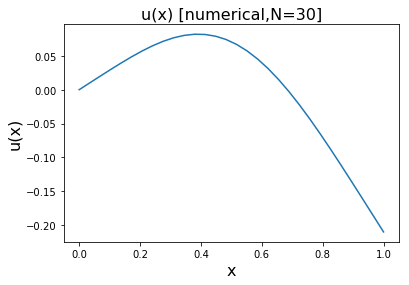

In [10]:
plt.plot(x,u)
plt.ylabel('u(x)', fontsize=fs_med)
plt.xlabel('x', fontsize=fs_med)
plt.title('u(x) [numerical,N=30]', fontsize=fs_med)

### Part 5) Compare answer with exact solution

#### Solving for $u(x)$ analytically

Since $u=u(x)$ we can easily solve this equation analytically by integrating twice...

$$\frac{\partial u}{\partial x} = \frac{1}{2\pi}\sin{(2\pi x)} - x + A$$
$$u(x) = \frac{-1}{(2\pi)^2}\cos{(2\pi x)} - \frac{x^2}{2} + Ax + B$$

Applying the BCs gives:

$$u(0) = 0 = \frac{-1}{(2\pi)^2} + B \rightarrow \boxed{B=\frac{1}{(2\pi)^2}}$$
$$\int_0^1 u(x)\,dx = 0 = \left[ \frac{1}{(2\pi)^2}\left(x-\frac{\sin{(2\pi)}}{2\pi}\right) - \frac{x^3}{6} + \frac{Ax^2}{2} \right]^1_0\rightarrow \boxed{A=\frac13 - \frac{1}{2\pi^2}}$$


And plugging $A$ and $B$ into our solution gives:
$$\boxed{u(x) = \frac{1}{(2\pi)^2} \left(1 - \cos{2\pi x} \right) - \frac{x^2}{2} + \left(\frac13 - \frac{1}{2\pi^2}\right)x}$$

In [11]:
ua = (1-np.cos(2*np.pi*x))/(2*np.pi)**2 - x**2/2 + (1/3 - 1/(2*np.pi**2))*x

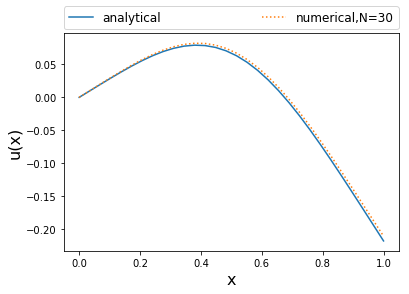

In [12]:
plt.plot(x,ua, label="analytical")
plt.plot(x,u,linestyle=':', label="numerical,N=30")
plt.ylabel('u(x)', fontsize=fs_med)
plt.xlabel('x', fontsize=fs_med)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=12)

Numerical solution seems to match the analytical solution fairly well!